In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
!pip install -q transformers

In [4]:
!pip install -q datasets jiwer

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 471.6/471.6 kB 25.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 9.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.1/3.1 MB 41.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 12.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 14.9 MB/s eta 0:00:00


In [5]:
from pathlib import Path
data_dir = Path("/content/drive/MyDrive/Images/Images/")
images = list(data_dir.glob("*.png"))
print("Number of images found: ", len(images))



Number of images found:  1020


In [6]:
import pandas as pd
dataset = []

# Iterate over the dataset and store the
# information needed
for img_path in images:
    # 1. Get the label associated with each image
    label = img_path.name.split(".png")[0]
    # 3. Store the image-label pair info
    img_path=str(img_path).split("/")[-1]
    dataset.append((str(img_path), label))

dataset = pd.DataFrame(dataset, columns=["file_name", "text"], index=None)

# Shuffle the dataset
dataset = dataset.sample(frac=1.).reset_index(drop=True)

In [7]:
dataset.head()

,file_name,text
0,6f4mwng.png,6f4mwng
1,e8ynwfd.png,e8ynwfd
2,n3c5ee.png,n3c5ee
3,3dx3p45.png,3dx3p45
4,ybwxwn.png,ybwxwn


We split up the data into training + testing, using sklearn's `train_test_split` function.

In [8]:
from sklearn.model_selection import train_test_split

train_df, test_df = train_test_split(dataset, test_size=0.2)
# we reset the indices to start from zero
train_df.reset_index(drop=True, inplace=True)
test_df.reset_index(drop=True, inplace=True)

In [9]:
import torch
from torch.utils.data import Dataset
from PIL import Image

class IAMDataset(Dataset):
    def __init__(self, root_dir, df, processor, max_target_length=128):
        self.root_dir = root_dir
        self.df = df
        self.processor = processor
        self.max_target_length = max_target_length

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        # get file name + text
        file_name = self.df['file_name'][idx]
        text = self.df['text'][idx]
        # prepare image (i.e. resize + normalize)
        image = Image.open(self.root_dir + file_name).convert("RGB")
        pixel_values = self.processor(image, return_tensors="pt").pixel_values
        # add labels (input_ids) by encoding the text
        labels = self.processor.tokenizer(text,
                                          padding="max_length",
                                          max_length=self.max_target_length).input_ids
        # important: make sure that PAD tokens are ignored by the loss function
        labels = [label if label != self.processor.tokenizer.pad_token_id else -100 for label in labels]

        encoding = {"pixel_values": pixel_values.squeeze(), "labels": torch.tensor(labels)}
        return encoding

Let's initialize the training and evaluation datasets:

In [10]:
!pip install sentencepiece

In [11]:
from transformers import TrOCRProcessor

processor = TrOCRProcessor.from_pretrained("microsoft/trocr-small-printed")
train_dataset = IAMDataset(root_dir='/content/drive/MyDrive/Images/Images/',
                           df=train_df,
                           processor=processor)
eval_dataset = IAMDataset(root_dir='/content/drive/MyDrive/Images/Images/',
                           df=test_df,
                           processor=processor)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


preprocessor_config.json:   0%|          | 0.00/272 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/327 [00:00<?, ?B/s]

sentencepiece.bpe.model:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/238 [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


In [12]:
print("Number of training examples:", len(train_dataset))
print("Number of validation examples:", len(eval_dataset))

Number of training examples: 816
Number of validation examples: 204


Let's verify an example from the training dataset:

In [13]:
encoding = train_dataset[0]
for k,v in encoding.items():
  print(k, v.shape)

pixel_values torch.Size([3, 384, 384])
labels torch.Size([128])


We can also check the original image and decode the labels:

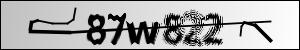

In [14]:
image = Image.open(train_dataset.root_dir + train_df['file_name'][0]).convert("RGB")
image

In [15]:
labels = encoding['labels']
labels[labels == -100] = processor.tokenizer.pad_token_id
label_str = processor.decode(labels, skip_special_tokens=True)
print(label_str)

87w822


Let's create corresponding dataloaders:

In [16]:
from torch.utils.data import DataLoader

train_dataloader = DataLoader(train_dataset, batch_size=24, shuffle=True)
eval_dataloader = DataLoader(eval_dataset, batch_size=24)

In [17]:
from transformers import VisionEncoderDecoderModel
import torch

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)
model = VisionEncoderDecoderModel.from_pretrained("microsoft/trocr-small-printed")
model.to(device)

cuda


config.json:   0%|          | 0.00/4.21k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/246M [00:00<?, ?B/s]

Some weights of VisionEncoderDecoderModel were not initialized from the model checkpoint at microsoft/trocr-small-printed and are newly initialized: ['encoder.pooler.dense.bias', 'encoder.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


generation_config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

VisionEncoderDecoderModel(
  (encoder): DeiTModel(
    (embeddings): DeiTEmbeddings(
      (patch_embeddings): DeiTPatchEmbeddings(
        (projection): Conv2d(3, 384, kernel_size=(16, 16), stride=(16, 16))
      )
      (dropout): Dropout(p=0.0, inplace=False)
    )
    (encoder): DeiTEncoder(
      (layer): ModuleList(
        (0-11): 12 x DeiTLayer(
          (attention): DeiTAttention(
            (attention): DeiTSelfAttention(
              (query): Linear(in_features=384, out_features=384, bias=True)
              (key): Linear(in_features=384, out_features=384, bias=True)
              (value): Linear(in_features=384, out_features=384, bias=True)
              (dropout): Dropout(p=0.0, inplace=False)
            )
            (output): DeiTSelfOutput(
              (dense): Linear(in_features=384, out_features=384, bias=True)
              (dropout): Dropout(p=0.0, inplace=False)
            )
          )
          (intermediate): DeiTIntermediate(
            (dense): Linear(

Importantly, we need to set a couple of attributes, namely:
* the attributes required for creating the `decoder_input_ids` from the `labels` (the model will automatically create the `decoder_input_ids` by shifting the `labels` one position to the right and prepending the `decoder_start_token_id`, as well as replacing ids which are -100 by the pad_token_id)
* the vocabulary size of the model (for the language modeling head on top of the decoder)
* beam-search related parameters which are used when generating text.

In [18]:
# set special tokens used for creating the decoder_input_ids from the labels
model.config.decoder_start_token_id = processor.tokenizer.cls_token_id
model.config.pad_token_id = processor.tokenizer.pad_token_id
# make sure vocab size is set correctly
model.config.vocab_size = model.config.decoder.vocab_size

# set beam search parameters
model.config.eos_token_id = processor.tokenizer.sep_token_id
model.config.max_length = 64
model.config.early_stopping = True
model.config.no_repeat_ngram_size = 3
model.config.length_penalty = 2.0
model.config.num_beams = 4

In [19]:
%pip install evaluate

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.0/84.0 kB 8.1 MB/s eta 0:00:00


In [20]:
from evaluate import load
cer_metric = load("cer")

In [22]:
def compute_cer(pred_ids, label_ids):
    pred_str = processor.batch_decode(pred_ids, skip_special_tokens=True)
    label_ids[label_ids == -100] = processor.tokenizer.pad_token_id
    label_str = processor.batch_decode(label_ids, skip_special_tokens=True)

    cer = cer_metric.compute(predictions=pred_str, references=label_str)

    return cer

In [25]:
from transformers import AdamW
from tqdm.notebook import tqdm

optimizer = AdamW(model.parameters(), lr=5e-5)

for epoch in range(50):  # loop over the dataset multiple times
   # train
   model.train()
   train_loss = 0.0
   for batch in tqdm(train_dataloader):
      # get the inputs
      for k,v in batch.items():
        batch[k] = v.to(device)

      # forward + backward + optimize
      outputs = model(**batch)
      loss = outputs.loss
      loss.backward()
      optimizer.step()
      optimizer.zero_grad()

      train_loss += loss.item()

   print(f"Loss after epoch {epoch}:", train_loss/len(train_dataloader))

   # evaluate
   model.eval()
   valid_cer = 0.0
   with torch.no_grad():
     for batch in tqdm(eval_dataloader):
       # run batch generation
       outputs = model.generate(batch["pixel_values"].to(device))
       # compute metrics
       cer = compute_cer(pred_ids=outputs, label_ids=batch["labels"])
       valid_cer += cer

   total_cer = valid_cer / len(eval_dataloader)
   print("Validation CER:", total_cer)
   if total_cer < 0.05:
     import datetime
     save_pretrained_dir = f'drive/MyDrive/{total_cer}_{epoch}_{datetime.datetime.now(datetime.timezone(datetime.timedelta(hours=9),"JST")).strftime("%Y%m%dT%H%M%S")}'
     model.save_pretrained(save_pretrained_dir)
     print("model weights added")
model.save_pretrained(".")


  0%|          | 0/34 [00:00<?, ?it/s]

Loss after epoch 0: 0.6605789529926637


  0%|          | 0/9 [00:00<?, ?it/s]

Some non-default generation parameters are set in the model config. These should go into a GenerationConfig file (https://huggingface.co/docs/transformers/generation_strategies#save-a-custom-decoding-strategy-with-your-model) instead. This warning will be raised to an exception in v4.41.
Non-default generation parameters: {'max_length': 64, 'early_stopping': True, 'num_beams': 4, 'length_penalty': 2.0, 'no_repeat_ngram_size': 3}


Validation CER: 0.07742470387434781
model weights added


  0%|          | 0/34 [00:00<?, ?it/s]

Loss after epoch 1: 0.36302003264427185


  0%|          | 0/9 [00:00<?, ?it/s]

Some non-default generation parameters are set in the model config. These should go into a GenerationConfig file (https://huggingface.co/docs/transformers/generation_strategies#save-a-custom-decoding-strategy-with-your-model) instead. This warning will be raised to an exception in v4.41.
Non-default generation parameters: {'max_length': 64, 'early_stopping': True, 'num_beams': 4, 'length_penalty': 2.0, 'no_repeat_ngram_size': 3}


Validation CER: 0.09362305171590429
model weights added


  0%|          | 0/34 [00:00<?, ?it/s]

Loss after epoch 2: 0.35518450684407177


  0%|          | 0/9 [00:00<?, ?it/s]

Some non-default generation parameters are set in the model config. These should go into a GenerationConfig file (https://huggingface.co/docs/transformers/generation_strategies#save-a-custom-decoding-strategy-with-your-model) instead. This warning will be raised to an exception in v4.41.
Non-default generation parameters: {'max_length': 64, 'early_stopping': True, 'num_beams': 4, 'length_penalty': 2.0, 'no_repeat_ngram_size': 3}


Validation CER: 0.09142870789227463
model weights added


  0%|          | 0/34 [00:00<?, ?it/s]

Loss after epoch 3: 0.39254263919942517


  0%|          | 0/9 [00:00<?, ?it/s]

Some non-default generation parameters are set in the model config. These should go into a GenerationConfig file (https://huggingface.co/docs/transformers/generation_strategies#save-a-custom-decoding-strategy-with-your-model) instead. This warning will be raised to an exception in v4.41.
Non-default generation parameters: {'max_length': 64, 'early_stopping': True, 'num_beams': 4, 'length_penalty': 2.0, 'no_repeat_ngram_size': 3}


Validation CER: 0.08784186346998786
model weights added


  0%|          | 0/34 [00:00<?, ?it/s]

Loss after epoch 4: 0.4115706800537951


  0%|          | 0/9 [00:00<?, ?it/s]

Some non-default generation parameters are set in the model config. These should go into a GenerationConfig file (https://huggingface.co/docs/transformers/generation_strategies#save-a-custom-decoding-strategy-with-your-model) instead. This warning will be raised to an exception in v4.41.
Non-default generation parameters: {'max_length': 64, 'early_stopping': True, 'num_beams': 4, 'length_penalty': 2.0, 'no_repeat_ngram_size': 3}


Validation CER: 0.09743601292945679
model weights added


  0%|          | 0/34 [00:00<?, ?it/s]

Loss after epoch 5: 0.25197775486637564


  0%|          | 0/9 [00:00<?, ?it/s]

Some non-default generation parameters are set in the model config. These should go into a GenerationConfig file (https://huggingface.co/docs/transformers/generation_strategies#save-a-custom-decoding-strategy-with-your-model) instead. This warning will be raised to an exception in v4.41.
Non-default generation parameters: {'max_length': 64, 'early_stopping': True, 'num_beams': 4, 'length_penalty': 2.0, 'no_repeat_ngram_size': 3}


Validation CER: 0.041356407294353095
model weights added


  0%|          | 0/34 [00:00<?, ?it/s]

Loss after epoch 6: 0.09458429848446566


  0%|          | 0/9 [00:00<?, ?it/s]

Some non-default generation parameters are set in the model config. These should go into a GenerationConfig file (https://huggingface.co/docs/transformers/generation_strategies#save-a-custom-decoding-strategy-with-your-model) instead. This warning will be raised to an exception in v4.41.
Non-default generation parameters: {'max_length': 64, 'early_stopping': True, 'num_beams': 4, 'length_penalty': 2.0, 'no_repeat_ngram_size': 3}


Validation CER: 0.0339316738235501
model weights added


  0%|          | 0/34 [00:00<?, ?it/s]

Loss after epoch 7: 0.05430493191541994


  0%|          | 0/9 [00:00<?, ?it/s]

Some non-default generation parameters are set in the model config. These should go into a GenerationConfig file (https://huggingface.co/docs/transformers/generation_strategies#save-a-custom-decoding-strategy-with-your-model) instead. This warning will be raised to an exception in v4.41.
Non-default generation parameters: {'max_length': 64, 'early_stopping': True, 'num_beams': 4, 'length_penalty': 2.0, 'no_repeat_ngram_size': 3}


Validation CER: 0.023931270226359738
model weights added


  0%|          | 0/34 [00:00<?, ?it/s]

Loss after epoch 8: 0.1764086237834657


  0%|          | 0/9 [00:00<?, ?it/s]

Some non-default generation parameters are set in the model config. These should go into a GenerationConfig file (https://huggingface.co/docs/transformers/generation_strategies#save-a-custom-decoding-strategy-with-your-model) instead. This warning will be raised to an exception in v4.41.
Non-default generation parameters: {'max_length': 64, 'early_stopping': True, 'num_beams': 4, 'length_penalty': 2.0, 'no_repeat_ngram_size': 3}


Validation CER: 0.09358030190242994
model weights added


  0%|          | 0/34 [00:00<?, ?it/s]

Loss after epoch 9: 0.08385729077546035


  0%|          | 0/9 [00:00<?, ?it/s]

Some non-default generation parameters are set in the model config. These should go into a GenerationConfig file (https://huggingface.co/docs/transformers/generation_strategies#save-a-custom-decoding-strategy-with-your-model) instead. This warning will be raised to an exception in v4.41.
Non-default generation parameters: {'max_length': 64, 'early_stopping': True, 'num_beams': 4, 'length_penalty': 2.0, 'no_repeat_ngram_size': 3}


Validation CER: 0.02167309162626823
model weights added


  0%|          | 0/34 [00:00<?, ?it/s]

Loss after epoch 10: 0.03356967118623502


  0%|          | 0/9 [00:00<?, ?it/s]

Some non-default generation parameters are set in the model config. These should go into a GenerationConfig file (https://huggingface.co/docs/transformers/generation_strategies#save-a-custom-decoding-strategy-with-your-model) instead. This warning will be raised to an exception in v4.41.
Non-default generation parameters: {'max_length': 64, 'early_stopping': True, 'num_beams': 4, 'length_penalty': 2.0, 'no_repeat_ngram_size': 3}


Validation CER: 0.0382848688405878
model weights added


  0%|          | 0/34 [00:00<?, ?it/s]

Loss after epoch 11: 0.0633315955672194


  0%|          | 0/9 [00:00<?, ?it/s]

Some non-default generation parameters are set in the model config. These should go into a GenerationConfig file (https://huggingface.co/docs/transformers/generation_strategies#save-a-custom-decoding-strategy-with-your-model) instead. This warning will be raised to an exception in v4.41.
Non-default generation parameters: {'max_length': 64, 'early_stopping': True, 'num_beams': 4, 'length_penalty': 2.0, 'no_repeat_ngram_size': 3}


Validation CER: 0.031137688469572915
model weights added


  0%|          | 0/34 [00:00<?, ?it/s]

Loss after epoch 12: 0.03585116589880165


  0%|          | 0/9 [00:00<?, ?it/s]

Some non-default generation parameters are set in the model config. These should go into a GenerationConfig file (https://huggingface.co/docs/transformers/generation_strategies#save-a-custom-decoding-strategy-with-your-model) instead. This warning will be raised to an exception in v4.41.
Non-default generation parameters: {'max_length': 64, 'early_stopping': True, 'num_beams': 4, 'length_penalty': 2.0, 'no_repeat_ngram_size': 3}


Validation CER: 0.026105256272454816
model weights added


  0%|          | 0/34 [00:00<?, ?it/s]

Loss after epoch 13: 0.03868762822821736


  0%|          | 0/9 [00:00<?, ?it/s]

Some non-default generation parameters are set in the model config. These should go into a GenerationConfig file (https://huggingface.co/docs/transformers/generation_strategies#save-a-custom-decoding-strategy-with-your-model) instead. This warning will be raised to an exception in v4.41.
Non-default generation parameters: {'max_length': 64, 'early_stopping': True, 'num_beams': 4, 'length_penalty': 2.0, 'no_repeat_ngram_size': 3}


Validation CER: 0.026880855239946256
model weights added


  0%|          | 0/34 [00:00<?, ?it/s]

Loss after epoch 14: 0.07481074398931335


  0%|          | 0/9 [00:00<?, ?it/s]

Some non-default generation parameters are set in the model config. These should go into a GenerationConfig file (https://huggingface.co/docs/transformers/generation_strategies#save-a-custom-decoding-strategy-with-your-model) instead. This warning will be raised to an exception in v4.41.
Non-default generation parameters: {'max_length': 64, 'early_stopping': True, 'num_beams': 4, 'length_penalty': 2.0, 'no_repeat_ngram_size': 3}


Validation CER: 0.023861673502652208
model weights added


  0%|          | 0/34 [00:00<?, ?it/s]

Loss after epoch 15: 0.027155043228584176


  0%|          | 0/9 [00:00<?, ?it/s]

Some non-default generation parameters are set in the model config. These should go into a GenerationConfig file (https://huggingface.co/docs/transformers/generation_strategies#save-a-custom-decoding-strategy-with-your-model) instead. This warning will be raised to an exception in v4.41.
Non-default generation parameters: {'max_length': 64, 'early_stopping': True, 'num_beams': 4, 'length_penalty': 2.0, 'no_repeat_ngram_size': 3}


Validation CER: 0.018864782539970305
model weights added


  0%|          | 0/34 [00:00<?, ?it/s]

Loss after epoch 16: 0.07479576797991552


  0%|          | 0/9 [00:00<?, ?it/s]

Some non-default generation parameters are set in the model config. These should go into a GenerationConfig file (https://huggingface.co/docs/transformers/generation_strategies#save-a-custom-decoding-strategy-with-your-model) instead. This warning will be raised to an exception in v4.41.
Non-default generation parameters: {'max_length': 64, 'early_stopping': True, 'num_beams': 4, 'length_penalty': 2.0, 'no_repeat_ngram_size': 3}


Validation CER: 0.05506202077253827
model weights added


  0%|          | 0/34 [00:00<?, ?it/s]

Loss after epoch 17: 0.0732175297487308


  0%|          | 0/9 [00:00<?, ?it/s]

Some non-default generation parameters are set in the model config. These should go into a GenerationConfig file (https://huggingface.co/docs/transformers/generation_strategies#save-a-custom-decoding-strategy-with-your-model) instead. This warning will be raised to an exception in v4.41.
Non-default generation parameters: {'max_length': 64, 'early_stopping': True, 'num_beams': 4, 'length_penalty': 2.0, 'no_repeat_ngram_size': 3}


Validation CER: 0.04484679484991981
model weights added


  0%|          | 0/34 [00:00<?, ?it/s]

Loss after epoch 18: 0.022704393520732138


  0%|          | 0/9 [00:00<?, ?it/s]

Some non-default generation parameters are set in the model config. These should go into a GenerationConfig file (https://huggingface.co/docs/transformers/generation_strategies#save-a-custom-decoding-strategy-with-your-model) instead. This warning will be raised to an exception in v4.41.
Non-default generation parameters: {'max_length': 64, 'early_stopping': True, 'num_beams': 4, 'length_penalty': 2.0, 'no_repeat_ngram_size': 3}


Validation CER: 0.02904836296858467
model weights added


  0%|          | 0/34 [00:00<?, ?it/s]

Loss after epoch 19: 0.023140870185349795


  0%|          | 0/9 [00:00<?, ?it/s]

Some non-default generation parameters are set in the model config. These should go into a GenerationConfig file (https://huggingface.co/docs/transformers/generation_strategies#save-a-custom-decoding-strategy-with-your-model) instead. This warning will be raised to an exception in v4.41.
Non-default generation parameters: {'max_length': 64, 'early_stopping': True, 'num_beams': 4, 'length_penalty': 2.0, 'no_repeat_ngram_size': 3}


Validation CER: 0.03196602071372651
model weights added


  0%|          | 0/34 [00:00<?, ?it/s]

Loss after epoch 20: 0.05473888966747943


  0%|          | 0/9 [00:00<?, ?it/s]

Some non-default generation parameters are set in the model config. These should go into a GenerationConfig file (https://huggingface.co/docs/transformers/generation_strategies#save-a-custom-decoding-strategy-with-your-model) instead. This warning will be raised to an exception in v4.41.
Non-default generation parameters: {'max_length': 64, 'early_stopping': True, 'num_beams': 4, 'length_penalty': 2.0, 'no_repeat_ngram_size': 3}


Validation CER: 0.0361958390331206
model weights added


  0%|          | 0/34 [00:00<?, ?it/s]

Loss after epoch 21: 0.041528450900360066


  0%|          | 0/9 [00:00<?, ?it/s]

Some non-default generation parameters are set in the model config. These should go into a GenerationConfig file (https://huggingface.co/docs/transformers/generation_strategies#save-a-custom-decoding-strategy-with-your-model) instead. This warning will be raised to an exception in v4.41.
Non-default generation parameters: {'max_length': 64, 'early_stopping': True, 'num_beams': 4, 'length_penalty': 2.0, 'no_repeat_ngram_size': 3}


Validation CER: 0.024583172930793987
model weights added


  0%|          | 0/34 [00:00<?, ?it/s]

Loss after epoch 22: 0.026221127016469836


  0%|          | 0/9 [00:00<?, ?it/s]

Some non-default generation parameters are set in the model config. These should go into a GenerationConfig file (https://huggingface.co/docs/transformers/generation_strategies#save-a-custom-decoding-strategy-with-your-model) instead. This warning will be raised to an exception in v4.41.
Non-default generation parameters: {'max_length': 64, 'early_stopping': True, 'num_beams': 4, 'length_penalty': 2.0, 'no_repeat_ngram_size': 3}


Validation CER: 0.028973061098398773
model weights added


  0%|          | 0/34 [00:00<?, ?it/s]

Loss after epoch 23: 0.022250069387476232


  0%|          | 0/9 [00:00<?, ?it/s]

Some non-default generation parameters are set in the model config. These should go into a GenerationConfig file (https://huggingface.co/docs/transformers/generation_strategies#save-a-custom-decoding-strategy-with-your-model) instead. This warning will be raised to an exception in v4.41.
Non-default generation parameters: {'max_length': 64, 'early_stopping': True, 'num_beams': 4, 'length_penalty': 2.0, 'no_repeat_ngram_size': 3}


Validation CER: 0.023116402142970973
model weights added


  0%|          | 0/34 [00:00<?, ?it/s]

Loss after epoch 24: 0.01853161644163158


  0%|          | 0/9 [00:00<?, ?it/s]

Some non-default generation parameters are set in the model config. These should go into a GenerationConfig file (https://huggingface.co/docs/transformers/generation_strategies#save-a-custom-decoding-strategy-with-your-model) instead. This warning will be raised to an exception in v4.41.
Non-default generation parameters: {'max_length': 64, 'early_stopping': True, 'num_beams': 4, 'length_penalty': 2.0, 'no_repeat_ngram_size': 3}


Validation CER: 0.030435789338545946
model weights added


  0%|          | 0/34 [00:00<?, ?it/s]

Loss after epoch 25: 0.016272451975108945


  0%|          | 0/9 [00:00<?, ?it/s]

Some non-default generation parameters are set in the model config. These should go into a GenerationConfig file (https://huggingface.co/docs/transformers/generation_strategies#save-a-custom-decoding-strategy-with-your-model) instead. This warning will be raised to an exception in v4.41.
Non-default generation parameters: {'max_length': 64, 'early_stopping': True, 'num_beams': 4, 'length_penalty': 2.0, 'no_repeat_ngram_size': 3}


Validation CER: 0.036908221050181815
model weights added


  0%|          | 0/34 [00:00<?, ?it/s]

Loss after epoch 26: 0.009007240152534316


  0%|          | 0/9 [00:00<?, ?it/s]

Some non-default generation parameters are set in the model config. These should go into a GenerationConfig file (https://huggingface.co/docs/transformers/generation_strategies#save-a-custom-decoding-strategy-with-your-model) instead. This warning will be raised to an exception in v4.41.
Non-default generation parameters: {'max_length': 64, 'early_stopping': True, 'num_beams': 4, 'length_penalty': 2.0, 'no_repeat_ngram_size': 3}


Validation CER: 0.026110401685463327
model weights added


  0%|          | 0/34 [00:00<?, ?it/s]

Loss after epoch 27: 0.02115564691998503


  0%|          | 0/9 [00:00<?, ?it/s]

Some non-default generation parameters are set in the model config. These should go into a GenerationConfig file (https://huggingface.co/docs/transformers/generation_strategies#save-a-custom-decoding-strategy-with-your-model) instead. This warning will be raised to an exception in v4.41.
Non-default generation parameters: {'max_length': 64, 'early_stopping': True, 'num_beams': 4, 'length_penalty': 2.0, 'no_repeat_ngram_size': 3}


Validation CER: 0.031917936397921634
model weights added


  0%|          | 0/34 [00:00<?, ?it/s]

Loss after epoch 28: 0.09858282370602384


  0%|          | 0/9 [00:00<?, ?it/s]

Some non-default generation parameters are set in the model config. These should go into a GenerationConfig file (https://huggingface.co/docs/transformers/generation_strategies#save-a-custom-decoding-strategy-with-your-model) instead. This warning will be raised to an exception in v4.41.
Non-default generation parameters: {'max_length': 64, 'early_stopping': True, 'num_beams': 4, 'length_penalty': 2.0, 'no_repeat_ngram_size': 3}


Validation CER: 0.05434621763923694
model weights added


  0%|          | 0/34 [00:00<?, ?it/s]

Loss after epoch 29: 0.08087567754966371


  0%|          | 0/9 [00:00<?, ?it/s]

Some non-default generation parameters are set in the model config. These should go into a GenerationConfig file (https://huggingface.co/docs/transformers/generation_strategies#save-a-custom-decoding-strategy-with-your-model) instead. This warning will be raised to an exception in v4.41.
Non-default generation parameters: {'max_length': 64, 'early_stopping': True, 'num_beams': 4, 'length_penalty': 2.0, 'no_repeat_ngram_size': 3}


Validation CER: 0.041921747327415326
model weights added


  0%|          | 0/34 [00:00<?, ?it/s]

Loss after epoch 30: 0.05884164059534669


  0%|          | 0/9 [00:00<?, ?it/s]

Some non-default generation parameters are set in the model config. These should go into a GenerationConfig file (https://huggingface.co/docs/transformers/generation_strategies#save-a-custom-decoding-strategy-with-your-model) instead. This warning will be raised to an exception in v4.41.
Non-default generation parameters: {'max_length': 64, 'early_stopping': True, 'num_beams': 4, 'length_penalty': 2.0, 'no_repeat_ngram_size': 3}


Validation CER: 0.04790290339018561
model weights added


  0%|          | 0/34 [00:00<?, ?it/s]

Loss after epoch 31: 0.029300130164141163


  0%|          | 0/9 [00:00<?, ?it/s]

Some non-default generation parameters are set in the model config. These should go into a GenerationConfig file (https://huggingface.co/docs/transformers/generation_strategies#save-a-custom-decoding-strategy-with-your-model) instead. This warning will be raised to an exception in v4.41.
Non-default generation parameters: {'max_length': 64, 'early_stopping': True, 'num_beams': 4, 'length_penalty': 2.0, 'no_repeat_ngram_size': 3}


Validation CER: 0.03697087258020948
model weights added


  0%|          | 0/34 [00:00<?, ?it/s]

Loss after epoch 32: 0.0859343906152336


  0%|          | 0/9 [00:00<?, ?it/s]

Some non-default generation parameters are set in the model config. These should go into a GenerationConfig file (https://huggingface.co/docs/transformers/generation_strategies#save-a-custom-decoding-strategy-with-your-model) instead. This warning will be raised to an exception in v4.41.
Non-default generation parameters: {'max_length': 64, 'early_stopping': True, 'num_beams': 4, 'length_penalty': 2.0, 'no_repeat_ngram_size': 3}


Validation CER: 0.043655382500919174
model weights added


  0%|          | 0/34 [00:00<?, ?it/s]

Loss after epoch 33: 0.082167568452218


  0%|          | 0/9 [00:00<?, ?it/s]

Some non-default generation parameters are set in the model config. These should go into a GenerationConfig file (https://huggingface.co/docs/transformers/generation_strategies#save-a-custom-decoding-strategy-with-your-model) instead. This warning will be raised to an exception in v4.41.
Non-default generation parameters: {'max_length': 64, 'early_stopping': True, 'num_beams': 4, 'length_penalty': 2.0, 'no_repeat_ngram_size': 3}


Validation CER: 0.03788791107796655
model weights added


  0%|          | 0/34 [00:00<?, ?it/s]

Loss after epoch 34: 0.044982990688260865


  0%|          | 0/9 [00:00<?, ?it/s]

Some non-default generation parameters are set in the model config. These should go into a GenerationConfig file (https://huggingface.co/docs/transformers/generation_strategies#save-a-custom-decoding-strategy-with-your-model) instead. This warning will be raised to an exception in v4.41.
Non-default generation parameters: {'max_length': 64, 'early_stopping': True, 'num_beams': 4, 'length_penalty': 2.0, 'no_repeat_ngram_size': 3}


Validation CER: 0.03132967432840342
model weights added


  0%|          | 0/34 [00:00<?, ?it/s]

Loss after epoch 35: 0.029227495207177365


  0%|          | 0/9 [00:00<?, ?it/s]

Some non-default generation parameters are set in the model config. These should go into a GenerationConfig file (https://huggingface.co/docs/transformers/generation_strategies#save-a-custom-decoding-strategy-with-your-model) instead. This warning will be raised to an exception in v4.41.
Non-default generation parameters: {'max_length': 64, 'early_stopping': True, 'num_beams': 4, 'length_penalty': 2.0, 'no_repeat_ngram_size': 3}


Validation CER: 0.03130149233076074
model weights added


  0%|          | 0/34 [00:00<?, ?it/s]

Loss after epoch 36: 0.01710843956371879


  0%|          | 0/9 [00:00<?, ?it/s]

Some non-default generation parameters are set in the model config. These should go into a GenerationConfig file (https://huggingface.co/docs/transformers/generation_strategies#save-a-custom-decoding-strategy-with-your-model) instead. This warning will be raised to an exception in v4.41.
Non-default generation parameters: {'max_length': 64, 'early_stopping': True, 'num_beams': 4, 'length_penalty': 2.0, 'no_repeat_ngram_size': 3}


Validation CER: 0.03197171479050528
model weights added


  0%|          | 0/34 [00:00<?, ?it/s]

Loss after epoch 37: 0.013172038796576946


  0%|          | 0/9 [00:00<?, ?it/s]

Some non-default generation parameters are set in the model config. These should go into a GenerationConfig file (https://huggingface.co/docs/transformers/generation_strategies#save-a-custom-decoding-strategy-with-your-model) instead. This warning will be raised to an exception in v4.41.
Non-default generation parameters: {'max_length': 64, 'early_stopping': True, 'num_beams': 4, 'length_penalty': 2.0, 'no_repeat_ngram_size': 3}


Validation CER: 0.03636655438459804
model weights added


  0%|          | 0/34 [00:00<?, ?it/s]

Loss after epoch 38: 0.00877193164299516


  0%|          | 0/9 [00:00<?, ?it/s]

Some non-default generation parameters are set in the model config. These should go into a GenerationConfig file (https://huggingface.co/docs/transformers/generation_strategies#save-a-custom-decoding-strategy-with-your-model) instead. This warning will be raised to an exception in v4.41.
Non-default generation parameters: {'max_length': 64, 'early_stopping': True, 'num_beams': 4, 'length_penalty': 2.0, 'no_repeat_ngram_size': 3}


Validation CER: 0.02841040980736689
model weights added


  0%|          | 0/34 [00:00<?, ?it/s]

Loss after epoch 39: 0.006897959098055521


  0%|          | 0/9 [00:00<?, ?it/s]

Some non-default generation parameters are set in the model config. These should go into a GenerationConfig file (https://huggingface.co/docs/transformers/generation_strategies#save-a-custom-decoding-strategy-with-your-model) instead. This warning will be raised to an exception in v4.41.
Non-default generation parameters: {'max_length': 64, 'early_stopping': True, 'num_beams': 4, 'length_penalty': 2.0, 'no_repeat_ngram_size': 3}


Validation CER: 0.03054917877358765
model weights added


  0%|          | 0/34 [00:00<?, ?it/s]

Loss after epoch 40: 0.007483840632416746


  0%|          | 0/9 [00:00<?, ?it/s]

Some non-default generation parameters are set in the model config. These should go into a GenerationConfig file (https://huggingface.co/docs/transformers/generation_strategies#save-a-custom-decoding-strategy-with-your-model) instead. This warning will be raised to an exception in v4.41.
Non-default generation parameters: {'max_length': 64, 'early_stopping': True, 'num_beams': 4, 'length_penalty': 2.0, 'no_repeat_ngram_size': 3}


Validation CER: 0.02624713668842185
model weights added


  0%|          | 0/34 [00:00<?, ?it/s]

Loss after epoch 41: 0.005495767246055252


  0%|          | 0/9 [00:00<?, ?it/s]

Some non-default generation parameters are set in the model config. These should go into a GenerationConfig file (https://huggingface.co/docs/transformers/generation_strategies#save-a-custom-decoding-strategy-with-your-model) instead. This warning will be raised to an exception in v4.41.
Non-default generation parameters: {'max_length': 64, 'early_stopping': True, 'num_beams': 4, 'length_penalty': 2.0, 'no_repeat_ngram_size': 3}


Validation CER: 0.018873669909935074
model weights added


  0%|          | 0/34 [00:00<?, ?it/s]

Loss after epoch 42: 0.00709223303505603


  0%|          | 0/9 [00:00<?, ?it/s]

Some non-default generation parameters are set in the model config. These should go into a GenerationConfig file (https://huggingface.co/docs/transformers/generation_strategies#save-a-custom-decoding-strategy-with-your-model) instead. This warning will be raised to an exception in v4.41.
Non-default generation parameters: {'max_length': 64, 'early_stopping': True, 'num_beams': 4, 'length_penalty': 2.0, 'no_repeat_ngram_size': 3}


Validation CER: 0.02239846525893589
model weights added


  0%|          | 0/34 [00:00<?, ?it/s]

Loss after epoch 43: 0.022912304396467173


  0%|          | 0/9 [00:00<?, ?it/s]

Some non-default generation parameters are set in the model config. These should go into a GenerationConfig file (https://huggingface.co/docs/transformers/generation_strategies#save-a-custom-decoding-strategy-with-your-model) instead. This warning will be raised to an exception in v4.41.
Non-default generation parameters: {'max_length': 64, 'early_stopping': True, 'num_beams': 4, 'length_penalty': 2.0, 'no_repeat_ngram_size': 3}


Validation CER: 0.03620269214129045
model weights added


  0%|          | 0/34 [00:00<?, ?it/s]

Loss after epoch 44: 0.021371219259248498


  0%|          | 0/9 [00:00<?, ?it/s]

Some non-default generation parameters are set in the model config. These should go into a GenerationConfig file (https://huggingface.co/docs/transformers/generation_strategies#save-a-custom-decoding-strategy-with-your-model) instead. This warning will be raised to an exception in v4.41.
Non-default generation parameters: {'max_length': 64, 'early_stopping': True, 'num_beams': 4, 'length_penalty': 2.0, 'no_repeat_ngram_size': 3}


Validation CER: 0.08107080766963878
model weights added


  0%|          | 0/34 [00:00<?, ?it/s]

Loss after epoch 45: 0.0635416144368184


  0%|          | 0/9 [00:00<?, ?it/s]

Some non-default generation parameters are set in the model config. These should go into a GenerationConfig file (https://huggingface.co/docs/transformers/generation_strategies#save-a-custom-decoding-strategy-with-your-model) instead. This warning will be raised to an exception in v4.41.
Non-default generation parameters: {'max_length': 64, 'early_stopping': True, 'num_beams': 4, 'length_penalty': 2.0, 'no_repeat_ngram_size': 3}


Validation CER: 0.0479390991458423
model weights added


  0%|          | 0/34 [00:00<?, ?it/s]

Loss after epoch 46: 0.04429045889307471


  0%|          | 0/9 [00:00<?, ?it/s]

Some non-default generation parameters are set in the model config. These should go into a GenerationConfig file (https://huggingface.co/docs/transformers/generation_strategies#save-a-custom-decoding-strategy-with-your-model) instead. This warning will be raised to an exception in v4.41.
Non-default generation parameters: {'max_length': 64, 'early_stopping': True, 'num_beams': 4, 'length_penalty': 2.0, 'no_repeat_ngram_size': 3}


Validation CER: 0.04488677603843816
model weights added


  0%|          | 0/34 [00:00<?, ?it/s]

Loss after epoch 47: 0.058122781844919216


  0%|          | 0/9 [00:00<?, ?it/s]

Some non-default generation parameters are set in the model config. These should go into a GenerationConfig file (https://huggingface.co/docs/transformers/generation_strategies#save-a-custom-decoding-strategy-with-your-model) instead. This warning will be raised to an exception in v4.41.
Non-default generation parameters: {'max_length': 64, 'early_stopping': True, 'num_beams': 4, 'length_penalty': 2.0, 'no_repeat_ngram_size': 3}


Validation CER: 0.05535289375195941
model weights added


  0%|          | 0/34 [00:00<?, ?it/s]

Loss after epoch 48: 0.04752887426601613


  0%|          | 0/9 [00:00<?, ?it/s]

Some non-default generation parameters are set in the model config. These should go into a GenerationConfig file (https://huggingface.co/docs/transformers/generation_strategies#save-a-custom-decoding-strategy-with-your-model) instead. This warning will be raised to an exception in v4.41.
Non-default generation parameters: {'max_length': 64, 'early_stopping': True, 'num_beams': 4, 'length_penalty': 2.0, 'no_repeat_ngram_size': 3}


Validation CER: 0.0465810025801899
model weights added


  0%|          | 0/34 [00:00<?, ?it/s]

Loss after epoch 49: 0.028896738925729606


  0%|          | 0/9 [00:00<?, ?it/s]

Some non-default generation parameters are set in the model config. These should go into a GenerationConfig file (https://huggingface.co/docs/transformers/generation_strategies#save-a-custom-decoding-strategy-with-your-model) instead. This warning will be raised to an exception in v4.41.
Non-default generation parameters: {'max_length': 64, 'early_stopping': True, 'num_beams': 4, 'length_penalty': 2.0, 'no_repeat_ngram_size': 3}


Validation CER: 0.04486711136422065


Some non-default generation parameters are set in the model config. These should go into a GenerationConfig file (https://huggingface.co/docs/transformers/generation_strategies#save-a-custom-decoding-strategy-with-your-model) instead. This warning will be raised to an exception in v4.41.
Non-default generation parameters: {'max_length': 64, 'early_stopping': True, 'num_beams': 4, 'length_penalty': 2.0, 'no_repeat_ngram_size': 3}


model weights added


## Inference

Note that after training, you can easily load the model using the .`from_pretrained(output_dir)` method.

For inference on new images, I refer to my inference notebook, that can also be found in my [Transformers Tutorials repository](https://github.com/NielsRogge/Transformers-Tutorials) on Github.

In [27]:
from IPython.display import display
from transformers import VisionEncoderDecoderModel
import torch
from PIL import Image
from transformers import TrOCRProcessor
import os

processor = TrOCRProcessor.from_pretrained("microsoft/trocr-small-printed")
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
predicted_labels={}
model2 = VisionEncoderDecoderModel.from_pretrained("/content/drive/MyDrive/new_model_6_weights/0.018873669909935074_41_20241013T163801")

path="/content/drive/MyDrive/unlabel_captcha/"
for im in  os.listdir(path):
  image = Image.open(path+im).convert("RGB")
  # display(image)

  generated_ids = model2.generate(processor(image, return_tensors="pt").pixel_values)
  print(processor.batch_decode(generated_ids, skip_special_tokens=True)[0])
  predicted_labels[im]=processor.batch_decode(generated_ids, skip_special_tokens=True)[0]

a454fa
pd365g7
nwnx74
82c2xn
2nn7mnd
da4mbe
376bwg2
58nenew
d32nBf
43ceby
52256m
cynfp4
a84bnn
w6x45wg
e74ng6
f5p7xg7
7a28ap
nwx2xmm
2efayc
am63ax
5f7g85
22cxnfn
ggedyn
3b737n
bf4nn4
gpcym87
2pbb8yc7
yp5adp
ddf372
d3cgma
32bb55
2fbdec
xgwnw4
ngamea
mp35e2
egmf48
wf4n8n
8mpx5xx
e5335y
273cn7e
m7n5x8
np8a3f


In [29]:
import csv
csv_file = 'predicted_labels_new_data.csv'
with open(csv_file, mode='w', newline='') as file:
    writer = csv.writer(file)

    # Write the header
    writer.writerow(['Image', 'Predicted_Label'])

    # Write the data
    for image, label in predicted_labels.items():
        writer.writerow([image, label])

print(f"Data has been written to {csv_file}")

Data has been written to predicted_labels_new_data.csv


In [30]:
!pip freeze > requirements.txt